# Aircraft analysis

## Introduction

In this analysis, data of aircraft crashes will be used to analyze the risk associated with aircrafts based on:
#### * category or type
#### * make/model
#### * number of passenger injuries
##### * Number of Engines and type
    
## Objective

Find aircrafts with the risk profile in order to answer following questions:
#####  * which aircraft make has the highest and lowest risk
#####  * which aircraft tends to sustain the most damage
#####  * what is the survival rate of passengers based on airplane models
#####  * which engine type is associated with the highest and lowest total injuries
    

### Import necessary libraries and declare magic command for graph display

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import chardet
from rich.console import Console
from rich.table import Table

%matplotlib inline


### Checking for encoding of csv file

making sure we know the encoding of the file that we will be using so we can make sure we  use the .read_csv() correctly

In [186]:
# using chardet module to detect the files encoding type
# Read a sample of the file

with open("AviationData.csv", "rb") as file:
    result = chardet.detect(file.read(100000))
    print(result)

#df = pd.read_csv("AviationData.csv", encoding=result['encoding'])


# Encoding of source data:
# as we can see below that encoding type is 'ascii',  but instructing the .read_csv() module to open in ascii returns errors 
# due to columns 6, 7 and 28 having dtypes that are not recognized in ascii. after doing some research, the unknown characters 
# to ascii were known to windows-1252 or cp-1252. low_memory=False to prevent a warning message from appearing. 
# For better control, chunksize flag can be specified



{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


### Read in and getting familiar with the dataset

In [187]:
aviation_data = pd.read_csv('AviationData.csv', encoding = 'cp1252', low_memory=False)
#aviation_data.shape

pd.set_option('display.max_columns', None)
aviation_data.tail(5)

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,Registration.Number,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,FAR.Description,Schedule,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
88884,2.02212E+13,Accident,ERA23LA093,12/26/2022,"Annapolis, MD",United States,NaN,NaN,NaN,NaN,Minor,NaN,NaN,N1867H,PIPER,PA-28-151,No,NaN,NaN,91,NaN,Personal,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,29-12-2022
88885,2.02212E+13,Accident,ERA23LA095,12/26/2022,"Hampton, NH",United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N2895Z,BELLANCA,7ECA,No,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
88886,2.02212E+13,Accident,WPR23LA075,12/26/2022,"Payson, AZ",United States,341525N,1112021W,PAN,PAYSON,Non-Fatal,Substantial,Airplane,N749PJ,AMERICAN CHAMPION AIRCRAFT,8GCBC,No,1.0,NaN,91,NaN,Personal,NaN,0.0,0.0,0.0,1.0,VMC,NaN,NaN,27-12-2022
88887,2.02212E+13,Accident,WPR23LA076,12/26/2022,"Morgan, UT",United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N210CU,CESSNA,210N,No,NaN,NaN,91,NaN,Personal,MC CESSNA 210N LLC,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
88888,2.02212E+13,Accident,ERA23LA097,12/29/2022,"Athens, GA",United States,NaN,NaN,NaN,NaN,Minor,NaN,NaN,N9026P,PIPER,PA-24-260,No,NaN,NaN,91,NaN,Personal,NaN,0.0,1.0,0.0,1.0,NaN,NaN,NaN,30-12-2022


### Subsetting data

All data in the source file has no use for our objective, therefore only data that can answer our questions will be used. lets also get some info about the data in order to know the columns we will be using

In [188]:
# creating subset of aviation_data that are relevant to analyzing safety risk. may add more if necassary

data_subset = aviation_data.iloc[:,[0,2,3,4,10,11,12,14,15,17,18,21,23,24,25,26,27,30]]

data_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Accident.Number         88889 non-null  object 
 2   Event.Date              88889 non-null  object 
 3   Location                88837 non-null  object 
 4   Injury.Severity         87889 non-null  object 
 5   Aircraft.damage         85695 non-null  object 
 6   Aircraft.Category       32287 non-null  object 
 7   Make                    88826 non-null  object 
 8   Model                   88797 non-null  object 
 9   Number.of.Engines       82805 non-null  float64
 10  Engine.Type             81812 non-null  object 
 11  Purpose.of.flight       82697 non-null  object 
 12  Total.Fatal.Injuries    77488 non-null  float64
 13  Total.Serious.Injuries  76379 non-null  float64
 14  Total.Minor.Injuries    76956 non-null

### Missing Data

There are some numerical columns that has missing data. We want to preserve the balance of overal data, so I would choose to use the mean to fill in missing values 

In [189]:
data_subset = data_subset.apply(lambda col: col.fillna(col.mean()) if col.dtype != 'O' else col)

data_subset.update(data_subset.iloc[:, 12:16].apply(pd.to_numeric, errors='coerce').round(0).astype('Int64'))

#lets also get rid of NaN from 'Aircraft.Category'. we know that this has to be a categorical type of data, so would rather have
# 'Unkown' instead
data_subset.fillna({'Aircraft.Category': 'Unknown'}, inplace=True)


data_subset.head(5)

#data_subset.fillna(data_subset.median(), inplace=True)


,Event.Id,Accident.Number,Event.Date,Location,Injury.Severity,Aircraft.damage,Aircraft.Category,Make,Model,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Publication.Date
0,20001218X45444,SEA87LA080,10/24/1948,"MOOSE CREEK, ID",Fatal(2),Destroyed,Unknown,Stinson,108-3,1.000000,Reciprocating,Personal,2,0,0,0,UNK,NaN
1,20001218X45447,LAX94LA336,7/19/1962,"BRIDGEPORT, CA",Fatal(4),Destroyed,Unknown,Piper,PA24-180,1.000000,Reciprocating,Personal,4,0,0,0,UNK,19-09-1996
2,20061025X01555,NYC07LA005,8/30/1974,"Saltville, VA",Fatal(3),Destroyed,Unknown,Cessna,172M,1.000000,Reciprocating,Personal,3,0,0,5,IMC,26-02-2007
3,20001218X45448,LAX96LA321,6/19/1977,"EUREKA, CA",Fatal(2),Destroyed,Unknown,Rockwell,112,1.000000,Reciprocating,Personal,2,0,0,0,IMC,12/9/2000
4,20041105X01764,CHI79FA064,8/2/1979,"Canton, OH",Fatal(1),Destroyed,Unknown,Cessna,501,1.146585,NaN,Personal,1,2,0,0,VMC,16-04-1980


### Injuries of all levels

lets add a new column named ' Total.Injuries ' next to all types of injuries to get a general number for all injuries sustained for each observation. We will use this to calculate aircraft passenger survival rate.

In [190]:
data_subset.insert(loc=15, column='Total.Injuries', value=data_subset[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries']].sum(axis=1))

data_subset.head(2)
#data_subset.info()

,Event.Id,Accident.Number,Event.Date,Location,Injury.Severity,Aircraft.damage,Aircraft.Category,Make,Model,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Injuries,Total.Uninjured,Weather.Condition,Publication.Date
0,20001218X45444,SEA87LA080,10/24/1948,"MOOSE CREEK, ID",Fatal(2),Destroyed,Unknown,Stinson,108-3,1.0,Reciprocating,Personal,2,0,0,2.0,0,UNK,NaN
1,20001218X45447,LAX94LA336,7/19/1962,"BRIDGEPORT, CA",Fatal(4),Destroyed,Unknown,Piper,PA24-180,1.0,Reciprocating,Personal,4,0,0,4.0,0,UNK,19-09-1996


### What type of aircrafts has the highest and lowest risk?

Lets group the aircrafts by category then by damage. Damage will be on the y axis and category will be on the x axis.
Based on the graph below some aircrafts has no damage history. But lowest to highest risk are: Glider, Helicopter, Airplane, and unkown.

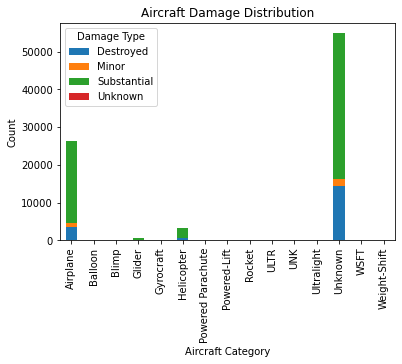

In [191]:
damage_counts = data_subset.groupby(['Aircraft.Category', 'Aircraft.damage']).size().reset_index(name='Count')

pivot_table = damage_counts.pivot(index='Aircraft.Category', columns='Aircraft.damage', values='Count')

# Bar chart (uncomment)
#pivot_table.plot(kind='bar')
# Stacked bar chart
pivot_table.plot(kind='bar', stacked=True)
plt.title('Aircraft Damage Distribution')
plt.xlabel('Aircraft Category')
plt.ylabel('Count')
plt.legend(title='Damage Type')
plt.show()


In [ ]:
# Suprisingly, there are a lot of unknown aircraft in the graph shown above. manually looking at the data, 
# I noticed some entries has 'Unkown' value in the Aircraft.Category. At the same time in the same entry the Make and Model 
# columns has values in them. for example a 'Unkown' value is present for Aircraft.Category column, 'Cessna' value for a 
# Make column and '140' for a Model column is present, but for another entry with the Model being different such as having '180', 
# the Aircraft.Category has a 'unknown' value. I did some research and discovered that a Cessna 140 and 180 looks pretty much 
# the same. I decided to use deductive reasoning to categorize some aircrafts with reference to other columns values.

### Replaced unknowns Aircraft Category
Some airplanes models have "unknown" in "Aircraft.Category", while the same aircraft in a different incident are known.Therefore
matched the same name of aircraft with aircraft category

In [192]:
df = data_subset

# Create a mapping from 'Make' & 'Model' to 'Aircraft.Category' where category is not 'Unknown'
category_mapping = (
    df[df['Aircraft.Category'].notna() & (df['Aircraft.Category'] != 'Unknown')]
    .groupby(['Make', 'Model'])['Aircraft.Category']
    .agg(lambda x: x.mode()[0] if not x.mode().empty else None)  # Get most frequent category
    .dropna()
)

# Replace 'Unknown' values by mapping 'Make' & 'Model' combinations
mask = df['Aircraft.Category'].isin(['Unknown', None])  # Identify 'Unknown' rows
df.loc[mask, 'Aircraft.Category'] = df.loc[mask, ['Make', 'Model']].apply(
    lambda row: category_mapping.get((row['Make'], row['Model'])), axis=1
)

# Fill remaining 'Unknown' values based only on 'Make' if 'Model' didn't find a match
category_mapping_make = (
    df[df['Aircraft.Category'].notna() & (df['Aircraft.Category'] != 'Unknown')]
    .groupby('Make')['Aircraft.Category']
    .agg(lambda x: x.mode()[0] if not x.mode().empty else None)
    .dropna()
)

df.loc[mask, 'Aircraft.Category'] = df.loc[mask, 'Make'].map(category_mapping_make)


Now lets graph the values again and see how many more unknown values has been filled with the airplane value in Aircraft.Category column

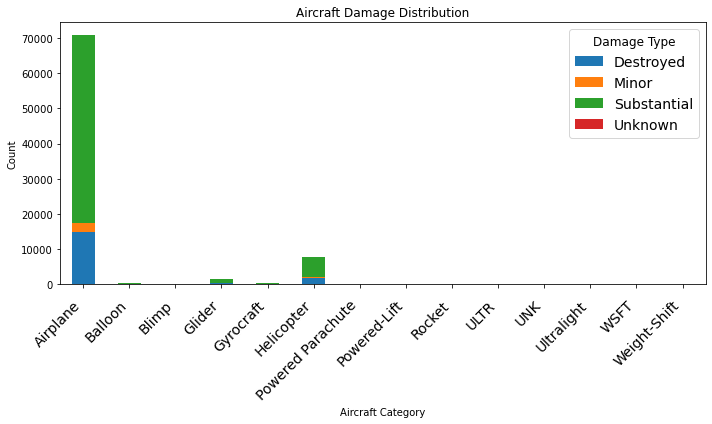

In [193]:
damage_counts = data_subset.groupby(['Aircraft.Category', 'Aircraft.damage']).size().reset_index(name='Count')

pivot_table = damage_counts.pivot(index='Aircraft.Category', columns='Aircraft.damage', values='Count')

pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Aircraft Damage Distribution')
plt.xlabel('Aircraft Category')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right', fontsize=14)
plt.tick_params(axis='x', pad=10) 
plt.legend(title='Damage Type', fontsize=14, title_fontsize=12)

plt.tight_layout()
plt.show()



I wanted to make sure that actual airplanes did not have 'Nan' values anymore so I created a dataframe with random samples of data to see if an actual airplane would have the 'Nan' value. if a make and model shows up with a 'Nan' value, I would research the make and model to see if it actually looks like an airplane that fits our business.

In [194]:
df = data_subset
# Filter rows where 'Aircraft.Category' is NaN
nan_category_df = df[df['Aircraft.Category'].isna()]

# Create a new dataset with a random sample of 10 rows (Change n as needed)
nan_category_sample_df = nan_category_df.sample(n=10)

# Display the new dataset
nan_category_sample_df.head(5)


,Event.Id,Accident.Number,Event.Date,Location,Injury.Severity,Aircraft.damage,Aircraft.Category,Make,Model,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Injuries,Total.Uninjured,Weather.Condition,Publication.Date
48631,20001212X21339,SEA00LA110,6/20/2000,"BIGFORK, MT",Fatal(2),Substantial,NaN,Hoye,KOLB TWINSTAR MK III,1.0,Reciprocating,Personal,2,0,0,2.0,0,VMC,9/5/2001
31228,20001211X15395,FTW92DPG15,8/19/1992,"BIRDEYE, AR",Non-Fatal,Substantial,NaN,Bell-transworld,47G-2,1.0,Reciprocating,Aerial Application,0,0,0,0.0,1,VMC,29-07-1993
5522,20001214X43685,CHI83LA325,7/19/1983,"FRANKLIN, IN",Non-Fatal,Substantial,NaN,E.r. Hutson,EAA BIPLANE,1.0,Reciprocating,Personal,0,0,0,0.0,1,VMC,NaN
44133,20001211X10354,LAX98LA195,6/14/1998,"SEDONA, AZ",Fatal(1),Destroyed,NaN,Blackmore,RV-4,1.0,Reciprocating,Personal,1,0,0,1.0,0,VMC,3/8/2000
16674,20001213X30081,LAX87DJA03,1/20/1987,"NAALEHU, HI",Non-Fatal,Destroyed,NaN,Emroth Emair,MA-1B,1.0,Reciprocating,Aerial Application,0,1,0,1.0,0,VMC,6/10/1988


### which aircraft has the highest and lowest risk between private and commercial

the business problem also specifies private and commercial aircrafts. The only column in the data that can be used to determine a private or commercial aircraft is the 'Purpose.of.flight' column. There are several values in this columns that does not specifically point to either category, so some research had to be done in order to categorize every value in this column into a private or commercial value. This step is at my descretion and can skew the data. I may potentially re-classify some of 'Purpose.of.Flight' from private to commercial and or the other way around.

Lets create a dictionary that contains the 'Purpose.of.Flight' column values to either Private, Commercial or Unknown

In [195]:
# Define the mapping dictionary
purpose_mapping = {
    'Personal': 'Private',
    'Business': 'Private',
    'Instructional': 'Private',
    'Executive/corporate': 'Private',
    'Skydiving': 'Private',
    'Other Work Use': 'Private',
    'Glider Tow': 'Private',
    'Air Race/show': 'Private',

    'Ferry': 'Commercial',
    'Aerial Observation': 'Commercial',
    'Aerial Application': 'Commercial',
    'Public Aircraft': 'Commercial',
    'Public Aircraft - Federal': 'Commercial',
    'Public Aircraft - Local': 'Commercial',
    'Public Aircraft - State': 'Commercial',
    'External Load': 'Commercial',
    'Banner Tow': 'Commercial',
    'Firefighting': 'Commercial',
    'Air Drop': 'Commercial',
    'Positioning': 'Commercial',
    'Flight Test': 'Commercial'
}

In [196]:
# Creating a new column by mapping values
data_subset['Private_or_Commercial'] = data_subset['Purpose.of.flight'].map(purpose_mapping)

# Filling any unmapped values with 'Unknown'
data_subset['Private_or_Commercial'].fillna('Unknown', inplace=True)

# Would rather this new column is next to the Purpose.of.flight column
data_subset.insert(12, 'Private_or_Commercial', data_subset.pop('Private_or_Commercial'))

data_subset.head(3)

,Event.Id,Accident.Number,Event.Date,Location,Injury.Severity,Aircraft.damage,Aircraft.Category,Make,Model,Number.of.Engines,Engine.Type,Purpose.of.flight,Private_or_Commercial,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Injuries,Total.Uninjured,Weather.Condition,Publication.Date
0,20001218X45444,SEA87LA080,10/24/1948,"MOOSE CREEK, ID",Fatal(2),Destroyed,Airplane,Stinson,108-3,1.0,Reciprocating,Personal,Private,2,0,0,2.0,0,UNK,NaN
1,20001218X45447,LAX94LA336,7/19/1962,"BRIDGEPORT, CA",Fatal(4),Destroyed,Airplane,Piper,PA24-180,1.0,Reciprocating,Personal,Private,4,0,0,4.0,0,UNK,19-09-1996
2,20061025X01555,NYC07LA005,8/30/1974,"Saltville, VA",Fatal(3),Destroyed,Airplane,Cessna,172M,1.0,Reciprocating,Personal,Private,3,0,0,3.0,5,IMC,26-02-2007


Lets group by the Private_or_Commercial and Aircraft.damage in order show a visual representation of the answer to our question  (what aircraft has the highest and lowest risk between private and commercial). We can see below that a majority of the aircrafts that got damages are in the private aircraft category.

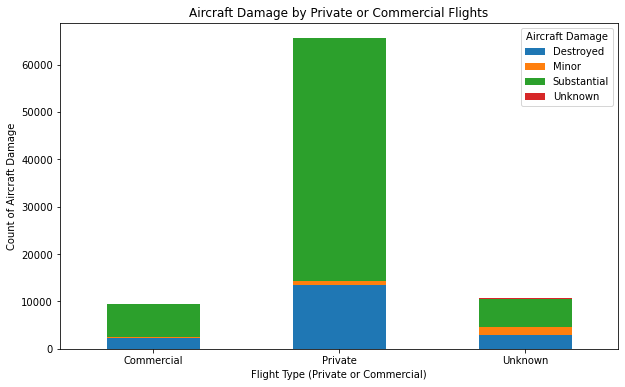

In [197]:

# Count occurrences of each Aircraft.damage type within Private_or_Commercial categories
damage_counts = data_subset.groupby(['Private_or_Commercial', 'Aircraft.damage']).size().unstack()

# Plot the data as a bar chart
damage_counts.plot(kind='bar', figsize=(10, 6), stacked=True)

# Set labels and title
plt.xlabel("Flight Type (Private or Commercial)")
plt.ylabel("Count of Aircraft Damage")
plt.title("Aircraft Damage by Private or Commercial Flights")
plt.xticks(rotation=0)

# Add legend
plt.legend(title="Aircraft Damage")

# Show the plot
plt.show()


### Too much irrelevant data
The data available dates back as early as 1948. Lets use only the last 20 years. earlier years would include airplanes that most likely would not meet today's industry standards

In [198]:
ap_after_2004 = data_subset[(data_subset['Aircraft.Category'] == 'Airplane')
                & (data_subset['Event.Date'] >= '2005-01-01')].copy()

# removed decimals from 'Number.of.Engines'
ap_after_2004['Number.of.Engines'] = ap_after_2004['Number.of.Engines'].astype(int)
#ap_after_2004.update(ap_after_2004.iloc[:, 13:18].apply(pd.to_numeric, errors='coerce').round(0).astype('Int64'))

# group lowercase and uppercase names of aircrafts to uppercase
ap_after_2004['Make'] = ap_after_2004['Make'].str.upper()


#ap_after_2004.iloc[:,13:19] = ap_after_2004.iloc[:,13:19].astype(int)
ap_after_2004.head()

,Event.Id,Accident.Number,Event.Date,Location,Injury.Severity,Aircraft.damage,Aircraft.Category,Make,Model,Number.of.Engines,Engine.Type,Purpose.of.flight,Private_or_Commercial,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Injuries,Total.Uninjured,Weather.Condition,Publication.Date
1,20001218X45447,LAX94LA336,7/19/1962,"BRIDGEPORT, CA",Fatal(4),Destroyed,Airplane,PIPER,PA24-180,1,Reciprocating,Personal,Private,4,0,0,4.0,0,UNK,19-09-1996
2,20061025X01555,NYC07LA005,8/30/1974,"Saltville, VA",Fatal(3),Destroyed,Airplane,CESSNA,172M,1,Reciprocating,Personal,Private,3,0,0,3.0,5,IMC,26-02-2007
3,20001218X45448,LAX96LA321,6/19/1977,"EUREKA, CA",Fatal(2),Destroyed,Airplane,ROCKWELL,112,1,Reciprocating,Personal,Private,2,0,0,2.0,0,IMC,12/9/2000
4,20041105X01764,CHI79FA064,8/2/1979,"Canton, OH",Fatal(1),Destroyed,Airplane,CESSNA,501,1,NaN,Personal,Private,1,2,0,3.0,0,VMC,16-04-1980
5,20170710X52551,NYC79AA106,9/17/1979,"BOSTON, MA",Non-Fatal,Substantial,Airplane,MCDONNELL DOUGLAS,DC9,2,Turbo Fan,NaN,Unknown,1,0,1,2.0,44,VMC,19-09-2017


### which manufacturer makes the lowest risk aircraft

unfortunately the data set does not have a column for manufacturers. Intuitively I attempted to plot 'Total.Injuries' against 'Make', but there are thousands of unique makes in the 'Make' column and does not plot a good graph. I was hoping to get a risk profile based on manufacturer. I decided to substitute 'Make' with 'Number.of.Engines' column

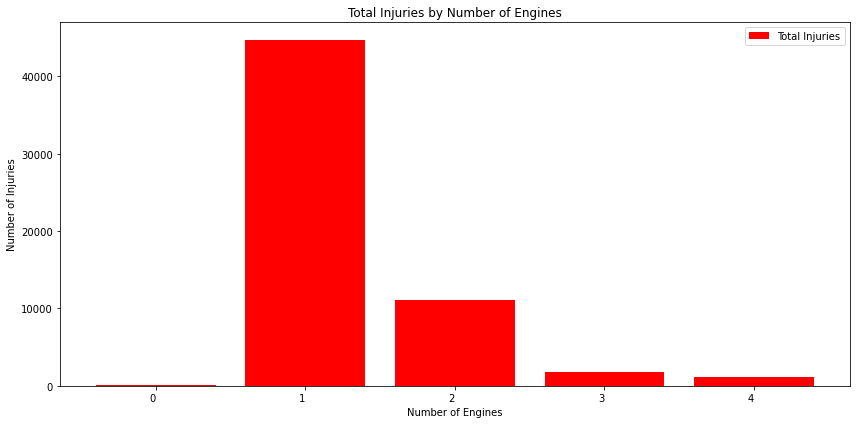

In [199]:
# Group by 'Make', summing up injuries
grouped_df = ap_after_2004.groupby(['Number.of.Engines'])[['Total.Injuries']].sum().reset_index()

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bar chart for Total Injuries
ax.bar(grouped_df['Number.of.Engines'], grouped_df['Total.Injuries'], color='red', label='Total Injuries')

# X-axis labels (Make)
ax.set_xticks(range(len(grouped_df)))
ax.set_xticklabels(grouped_df['Number.of.Engines'], ha="right")

# Labels and title
ax.set_xlabel('Number of Engines')
ax.set_ylabel('Number of Injuries')
ax.set_title('Total Injuries by Number of Engines')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


In [200]:
grouped_df.head()

,Number.of.Engines,Total.Injuries
0,0,152.0
1,1,44737.0
2,2,11091.0
3,3,1793.0
4,4,1123.0


The code below plots a graph of Total injuries by engine type. Reciprocating engine types by far are the most the most total injuries associated with it and Turbo jet has the least. 

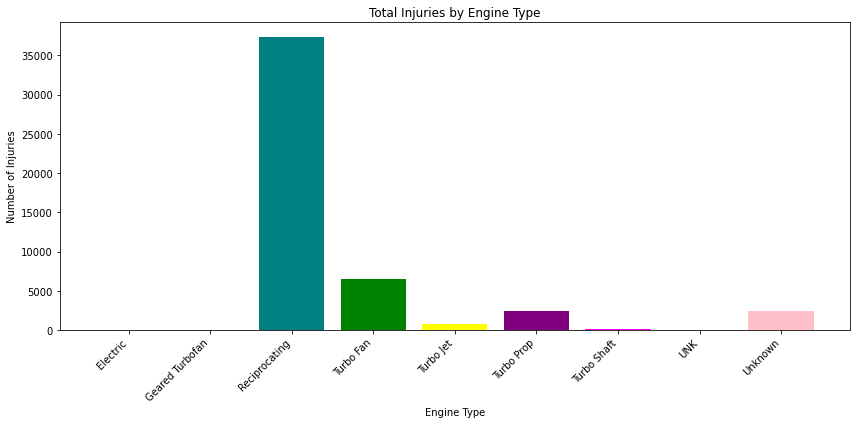

In [201]:

grouped_df = ap_after_2004.groupby(['Engine.Type'])[['Total.Injuries']].sum().reset_index()

# Define a list of specific colors (make sure it has enough colors for all bars)
color_list = ['red', 'blue', 'teal', 'green', 'yellow', 'purple', 'magenta', 'yellow', 'pink', 'brown']

# Ensure the number of colors matches the number of engine types
bar_colors = color_list[:len(grouped_df)]  # Slice to match the number of bars

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bar chart for Total Injuries by Engine Type with specific colors
bars = ax.bar(grouped_df['Engine.Type'], grouped_df['Total.Injuries'], color=bar_colors, label='Total Injuries')

# Set proper x-ticks and labels
ax.set_xticks(range(len(grouped_df)))  # Set tick positions
ax.set_xticklabels(grouped_df['Engine.Type'], rotation=45, ha="right")  # Set tick labels

# Labels and title
ax.set_xlabel('Engine Type')
ax.set_ylabel('Number of Injuries')
ax.set_title('Total Injuries by Engine Type')

# Show plot
plt.tight_layout()
plt.show()


### what is the the survival rate of passengers on each type of airplane

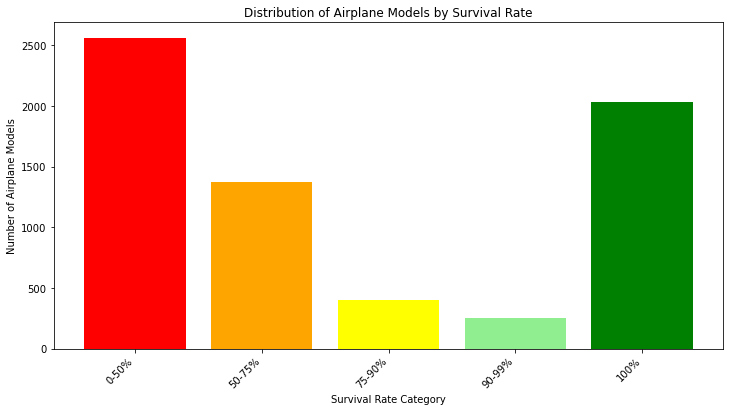

                                     Airplane Models by Survival Rate Category                                     
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Survival Category ┃ Airplane Models                                                                             ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       0-50%       │ HARVARD MK, RANS S-12 XL, A-23-19, A-23-23, SNJ-6B, BL, A-22, BA-2A-8, G44, ARNOLD AR 6...  │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────┤
│      50-75%       │ A-24-R, MD-600N, MD-11-F, MU-2B-36, MD-10-10F, Sportstar, 182-Q, C-1A, Saratoga II TC       │
│                   │ PA32-, MU-2B...                                                                             │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────┤
│      75-90%       │ G-V, DC-8-71F, PA 32-260, SA226, 681, MX-7-180A, 95-B55B, BN2A-2F, MD-83, B767-287ER...     │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────┤
│      90-99%       │ 777 - 236, F-100, 757-225, 777-222, 767-231ER, 757 2B7, F28 Mk 0100, 747-122, 727-223,      │
│                   │ 727-225...                                                                                  │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────┤
│       100%        │ &GCBC, LANCAIR IV P PROPJET, L-5, L1011-385, L16A, L21, L2A, AT 400A, L5, AT...             │
└───────────────────┴─────────────────────────────────────────────────────────────────────────────────────────────┘

In [202]:
df = ap_after_2004

# Filter only 'Airplane' category
df_airplane = df[df['Aircraft.Category'] == 'Airplane'].copy()

# Ensure numerical columns have no NaN values
df_airplane[['Total.Injuries', 'Total.Uninjured']] = df_airplane[['Total.Injuries', 'Total.Uninjured']].fillna(0)

# Create 'Total.Passengers' column
df_airplane['Total.Passengers'] = df_airplane['Total.Injuries'] + df_airplane['Total.Uninjured']

# Remove rows where Total.Passengers is 0 to avoid division errors
df_airplane = df_airplane[df_airplane['Total.Passengers'] > 0]

# Compute survival rates for each Airplane Model
survival_by_model = df_airplane.groupby('Model')[['Total.Injuries', 'Total.Uninjured', 'Total.Passengers']].sum()
survival_by_model['Survival Rate'] = survival_by_model['Total.Uninjured'] / survival_by_model['Total.Passengers']

# Sort models by Survival Rate
survival_by_model = survival_by_model.sort_values('Survival Rate', ascending=False)

# Define survival rate ranges (bins) and labels
bins = [0, 0.5, 0.75, 0.9, 0.99, 1.0]  
labels = ["0-50%", "50-75%", "75-90%", "90-99%", "100%"]
colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']  # Matching colors for chart & text

# Assign each model to a survival category
survival_by_model['Survival Category'] = pd.cut(survival_by_model['Survival Rate'], bins=bins, labels=labels, include_lowest=True)

# Count how many airplane models fall into each survival category
category_counts = survival_by_model['Survival Category'].value_counts().sort_index()

# Plot grouped survival rates
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(category_counts.index, category_counts.values, color=colors)

ax.set_xlabel("Survival Rate Category")
ax.set_ylabel("Number of Airplane Models")
ax.set_title("Distribution of Airplane Models by Survival Rate")
ax.set_xticks(range(len(category_counts)))
ax.set_xticklabels(category_counts.index, rotation=45, ha="right")

plt.show()

# Use Rich to display a table with model names per category, matching colors
console = Console()

table = Table(title="Airplane Models by Survival Rate Category", show_lines=True)
table.add_column("Survival Category", justify="center", style="bold cyan")
table.add_column("Airplane Models", justify="left")

# Loop through each category, applying corresponding color
for category, color in zip(labels, colors):
    models_in_category = survival_by_model[survival_by_model['Survival Category'] == category].index.tolist()
    model_display = ', '.join(models_in_category[:10]) + ('...' if len(models_in_category) > 5 else '')  # Show first 5 models per category
    
    # Apply the same color from the bar chart to the Rich text
    table.add_row(f"[{color}]{category}[/{color}]", f"[{color}]{model_display}[/{color}]")

console.print(table)

# Save processed survival data for Tableau
survival_by_model.to_csv("survival_by_model.csv")
category_counts.to_csv("category_counts.csv")



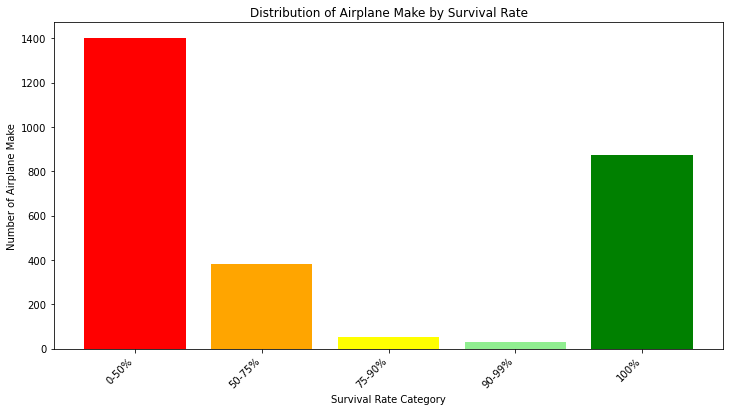

                                    Airplane Make by Survival Rate Category                                    
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Survival Category ┃ Airplane Make                                                                           ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       0-50%       │ CROSS-CAPPS, S.C. AEROSTAR S.A., PAHNKE VERNON A, TOMASH, RYAN AERONAUTICS...           │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│      50-75%       │ AEROPRO CZ S R O, JUST AIRCRAFT LLC, S.O.C.A.T.A., STAMPE, KEITH...                     │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│      75-90%       │ HAWKER, STEARMAN AIRCRAFT, SONERAI, AMERICAN LEGEND, BOEING COMPANY...                  │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│      90-99%       │ BOMBARDIER, EMBRAER S.A., SHORT BROTHERS, BOMBARDIER INC, BOEING OF CANADA/DEHAV DIV... │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│       100%        │ ZWICKER MURRAY R, GROSCH, HACHEM ZACHERY S, GUNNOE, GULFSTREAM SCHWEIZER A/C CORP...    │
└───────────────────┴─────────────────────────────────────────────────────────────────────────────────────────┘

In [203]:
df = ap_after_2004

# Filter only 'Airplane' category
df_airplane = df[df['Aircraft.Category'] == 'Airplane'].copy()

# Ensure numerical columns have no NaN values
df_airplane[['Total.Injuries', 'Total.Uninjured']] = df_airplane[['Total.Injuries', 'Total.Uninjured']].fillna(0)

# Create 'Total.Passengers' column
df_airplane['Total.Passengers'] = df_airplane['Total.Injuries'] + df_airplane['Total.Uninjured']

# Remove rows where Total.Passengers is 0 to avoid division errors
df_airplane = df_airplane[df_airplane['Total.Passengers'] > 0]

# Compute survival rates for each Airplane Make (Manufacturer)
survival_by_make = df_airplane.groupby('Make')[['Total.Injuries', 'Total.Uninjured', 'Total.Passengers']].sum()
survival_by_make['Survival Rate'] = survival_by_make['Total.Uninjured'] / survival_by_make['Total.Passengers']

# Sort makes by Survival Rate
survival_by_make = survival_by_make.sort_values('Survival Rate', ascending=False)

# Define survival rate ranges (bins) and labels
bins = [0, 0.5, 0.75, 0.9, 0.99, 1.0]  
labels = ["0-50%", "50-75%", "75-90%", "90-99%", "100%"]
colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']  # Matching colors for chart & text

# Assign each Make to a survival category
survival_by_make['Survival Category'] = pd.cut(survival_by_make['Survival Rate'], bins=bins, labels=labels, include_lowest=True)

# Count how many airplane manufacturers fall into each survival category
category_counts = survival_by_make['Survival Category'].value_counts().sort_index()

# Plot grouped survival rates
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(category_counts.index, category_counts.values, color=colors)

ax.set_xlabel("Survival Rate Category")
ax.set_ylabel("Number of Airplane Make")
ax.set_title("Distribution of Airplane Make by Survival Rate")
ax.set_xticks(range(len(category_counts)))
ax.set_xticklabels(category_counts.index, rotation=45, ha="right")
plt.show()

# Use Rich to display a table with manufacturer names per category, matching colors
console = Console()

table = Table(title="Airplane Make by Survival Rate Category", show_lines=True)
table.add_column("Survival Category", justify="center", style="bold cyan")
table.add_column("Airplane Make", justify="left")

# Loop through each category, applying corresponding color
for category, color in zip(labels, colors):
    makes_in_category = survival_by_make[survival_by_make['Survival Category'] == category].index.tolist()
    make_display = ', '.join(makes_in_category[:5]) + ('...' if len(makes_in_category) > 5 else '')  # Show first 5 makes per category
    
    # Apply the same color from the bar chart to the Rich text
    table.add_row(f"[{color}]{category}[/{color}]", f"[{color}]{make_display}[/{color}]")

console.print(table)


In [204]:
ap_after_2004.to_csv('Aviation_airplanes_after_2004.csv', index=False)

In [205]:
data_subset.to_csv('data_subset.csv', index=False)

In [206]:
ap_after_2004.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50112 entries, 1 to 88603
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                50112 non-null  object 
 1   Accident.Number         50112 non-null  object 
 2   Event.Date              50112 non-null  object 
 3   Location                50087 non-null  object 
 4   Injury.Severity         49566 non-null  object 
 5   Aircraft.damage         48520 non-null  object 
 6   Aircraft.Category       50112 non-null  object 
 7   Make                    50105 non-null  object 
 8   Model                   50089 non-null  object 
 9   Number.of.Engines       50112 non-null  int64  
 10  Engine.Type             46864 non-null  object 
 11  Purpose.of.flight       46967 non-null  object 
 12  Private_or_Commercial   50112 non-null  object 
 13  Total.Fatal.Injuries    50112 non-null  object 
 14  Total.Serious.Injuries  50112 non-null

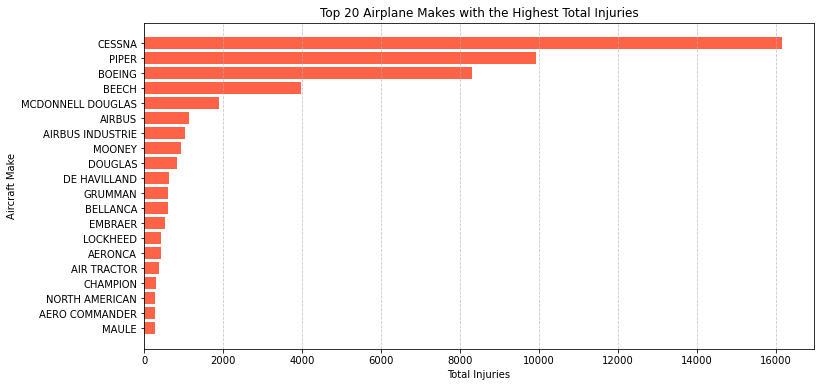

In [207]:
df = ap_after_2004

# Convert 'Total.Injuries' column to numeric (handling errors)
df["Total.Injuries"] = pd.to_numeric(df["Total.Injuries"], errors="coerce")

# Group by 'Make' and sum the total injuries
make_injuries = df.groupby("Make")["Total.Injuries"].sum().reset_index()

# Sort by total injuries in descending order and select the top 20
top_20_makes = make_injuries.sort_values(by="Total.Injuries", ascending=False).head(20)

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_20_makes["Make"], top_20_makes["Total.Injuries"], color="tomato")

# Invert Y-axis so the highest value is at the top
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel("Total Injuries")
plt.ylabel("Aircraft Make")
plt.title("Top 20 Airplane Makes with the Highest Total Injuries")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


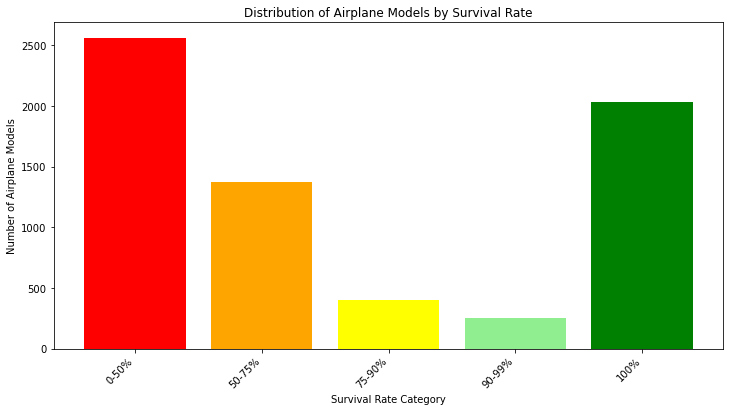

                                     Airplane Models by Survival Rate Category                                     
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Survival Category ┃ Airplane Models                                                                             ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       0-50%       │ 0-58B, 1, 1-A, 1000, 1000LT, 1002, 101, 11, 11-AC, 1100R, 111M, 112-TC, 1121B, 112B, 112TC, │
│                   │ 112TCA, ...                                                                                 │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────┤
│      50-75%       │ 0-1A, 10-A, 100-160, 100-180, 108, 108-1, 108-2, 108-3, 110, 112, 1121, 1124, 1124A, 112A,  │
│                   │ 114, 114-...                                                                                │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────┤
│      75-90%       │ 100, 110P1, 110SP, 112 TCA, 11CC, 120, 1329-23E, 150 G, 150-L, 152 II, 170, 172 SP, 172XP,  │
│                   │ 180, 180A...                                                                                │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────┤
│      90-99%       │ 10A, 145EP, 145LR, 1900D, 2000, 200C, 212-200, 319, 319-131, 3201, 340B, 350, 36A, 440,     │
│                   │ 560XL, 580, ...                                                                             │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────┤
│       100%        │ &GCBC, 0-47B, 058B, 1-11-204AF, 10, 10 GXE, 100 180, 104-80, 108 - 3, 108 1, 11 AC, 1125,   │
│                   │ 1125 WESTW...                                                                               │
└───────────────────┴─────────────────────────────────────────────────────────────────────────────────────────────┘

In [208]:
df = ap_after_2004

# Filter only 'Airplane' category
df_airplane = df[df['Aircraft.Category'] == 'Airplane'].copy()

# Ensure numerical columns have no NaN values
df_airplane[['Total.Injuries', 'Total.Uninjured']] = df_airplane[['Total.Injuries', 'Total.Uninjured']].fillna(0)

# Create 'Total.Passengers' column
df_airplane['Total.Passengers'] = df_airplane['Total.Injuries'] + df_airplane['Total.Uninjured']

# Remove rows where Total.Passengers is 0 to avoid division errors
df_airplane = df_airplane[df_airplane['Total.Passengers'] > 0]

# Compute survival rates for each Airplane Model
survival_by_model = df_airplane.groupby('Model', as_index=False)[['Total.Injuries', 'Total.Uninjured', 'Total.Passengers']].sum()
survival_by_model['Survival Rate'] = survival_by_model['Total.Uninjured'] / survival_by_model['Total.Passengers']

# Define survival rate ranges (bins) and labels
bins = [0, 0.5, 0.75, 0.9, 0.99, 1.0]  
labels = ["0-50%", "50-75%", "75-90%", "90-99%", "100%"]

# Assign each model to a survival category
survival_by_model['Survival Category'] = pd.cut(survival_by_model['Survival Rate'], bins=bins, labels=labels, include_lowest=True)

# Save processed survival data for Tableau (Ensure 'Model' is included)
survival_by_model.to_csv("survival_by_model.csv", index=False)

# Count how many airplane models fall into each survival category
category_counts = survival_by_model.groupby("Survival Category", as_index=False)["Model"].agg(lambda x: ', '.join(x))
category_counts.columns = ['Survival Category', 'Airplane Models']  # Rename columns for clarity

# Save category counts data for Tableau
category_counts.to_csv("category_counts.csv", index=False)

# Plot grouped survival rates
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']

bars = ax.bar(category_counts['Survival Category'], category_counts['Airplane Models'].str.count(',') + 1, color=colors)

ax.set_xlabel("Survival Rate Category")
ax.set_ylabel("Number of Airplane Models")
ax.set_title("Distribution of Airplane Models by Survival Rate")
ax.set_xticks(range(len(category_counts)))
ax.set_xticklabels(category_counts['Survival Category'], rotation=45, ha="right")

plt.show()

# Display table with Rich
console = Console()
table = Table(title="Airplane Models by Survival Rate Category", show_lines=True)
table.add_column("Survival Category", justify="center", style="bold cyan")
table.add_column("Airplane Models", justify="left")

for _, row in category_counts.iterrows():
    table.add_row(row["Survival Category"], row["Airplane Models"][:100] + ('...' if len(row["Airplane Models"]) > 100 else ''))

    
console.print(table)


In [209]:
#End